<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/image_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [2]:
data_dir = "/content/gdrive/MyDrive/rgb_video_data"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([126, 3, 240, 180])


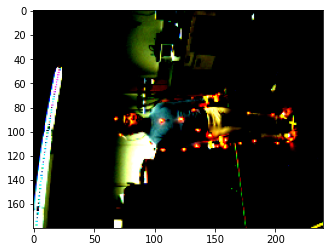

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet101
import random
import torch.nn.functional as F

subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

class BerkeleyMHAD(Dataset):

    def __init__(self, vid_names, root_dir, classes, transform=None):
        self.vid_names = vid_names # list of file names for videos (ex. S01_A01_R01)
        self.root_dir = root_dir # directory where videos are stored
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.vid_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.vid_names[idx])
        x = np.load(path)['x']
        
        data = []
        if self.transform:
            for i in range(x.shape[0]):
                data.append(self.transform(x[i]))
        
        vid_tensor = torch.stack(data)
        label = self.classes.index(np.load(path)['y']) 
        sample = {'x': vid_tensor, 'y': label}

        return sample

class cnn_block(nn.Module):
    def __init__(self):
        super(cnn_block, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.pool1 = nn.MaxPool2d(3)

        self._initialize_weights()

    def forward(self, x):
        batch = x.shape[0]
        x1 = self.pool1(F.relu(self.conv1(x)))
        x1 = self.pool1(F.relu(self.conv2(x1)))
        x1 = self.pool1(F.relu(self.conv3(x1)))
        x1 = F.relu(self.conv4(x1))
        x1 = x1.reshape(batch, -1).unsqueeze(0)

        return x1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0) 

class lstm_block(nn.Module):
    def __init__(self, classes):
        super(lstm_block, self).__init__()
        self.n_hidden = 128
        self.n_layers = 3
        self.l_lstm = torch.nn.LSTM(input_size = 1500, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, classes)

        self._initialize_weights()

    def forward(self, x):
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden).to(dev)
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).to(dev)
        self.hidden = (hidden_state, cell_state)

        lstm_out, hidden_out = self.l_lstm(x, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        lstm_out.retain_grad()
        out = lstm_out[:,-1,:]
        out = F.relu(self.fc2(out.squeeze()))
        out = self.fc3(out)

        return out, lstm_out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0)  


class cnn_lstm(nn.Module):
    def __init__(self, classes):
        super(cnn_lstm, self).__init__()
        self.cnn_block = cnn_block()
        self.lstm_block = lstm_block(classes)

    def forward(self, x):
        x1 = self.cnn_block(x)
        out, lstm_out = self.lstm_block(x1)

        return out, lstm_out


def check(i):
    #insert more i.find terms for each action
    return i.find('A01') != -1 or i.find('A02') != -1 or i.find('A05') != -1 or i.find('A07') != -1 
vid_names = [i for i in next(os.walk(data_dir))[2] if check(i)]

#vid_names = os.listdir(data_dir)
train_vid_names = [i for i in vid_names if i.find('S09') == -1 and i.find('S10') == -1 and i.find('S11') == -1 and i.find('S12') == -1]
valid_vid_names = [i for i in vid_names if i.find('S09') != -1 ]
test_vid_names = [i for i in vid_names if i.find('S10') != -1 or i.find('S11') != -1 or i.find('S12') != -1]

#data shape is (num_pics, height, width, channel)
Normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset = BerkeleyMHAD(train_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
valid_dataset = BerkeleyMHAD(valid_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
test_dataset = BerkeleyMHAD(test_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
plt.imshow(np.transpose(train_dataset[0]['x'][0]))
print(train_dataset[0]['x'].shape)

batch_size = 1

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#change 2 to number of classes

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
model = cnn_lstm(4).to(dev)
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/cnn_lstm_epoch_20_state_dict.pt'))
#resnet = resnet101(pretrained=True).to(dev)
#for param in resnet.parameters():
#    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epoch = 30
#train
shuffled = np.arange(len(train_dataset))

train_losses = []
val_losses = []
tcorrect = 0
ttotal = 0

for t in range(epoch):
    train_loss = 0
    valid_loss = 0
    tguess = []
    tanswers = []
    tcorrect = 0
    ttotal = 0
    random.shuffle(shuffled)

    model.train()

    for i in range(len(train_dataset)):
        optimizer.zero_grad()

        data = train_dataset[shuffled[i]]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        #inpt = resnet(inpt)
        output = model(inpt)[0].unsqueeze(0)
        loss = criterion(output, label) #.view(-1)
        loss.backward()
        optimizer.step()  
        #optimizer.zero_grad()
        train_loss += loss.item()
        
        if torch.argmax(output.squeeze()) == label:
            tcorrect += 1
        ttotal += 1
        #tanswers.append(label.item())
        #tguess.append(output[0][1].item())
        #tguess.append(torch.argmax(output.squeeze()))
        
    #grads = []
    #for param in model.parameters():
    #    if param.grad is not None:
    #        grads.append(param.grad.view(-1))
        
    #grads = torch.cat(grads)
    #print(torch.norm(grads))
    
    torch.cuda.empty_cache()   

    #with torch.no_grad():
    model.eval()
    for i in range(len(valid_dataset)):
        data = valid_dataset[i]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        output = model(inpt)[0].unsqueeze(0)
        loss = criterion(output, label)
        valid_loss += loss.item()
    print("epoch:", valid_loss / len(valid_dataset), train_loss / len(train_dataset))
    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(valid_loss / len(valid_dataset))
    if valid_loss / len(valid_dataset) <= min(val_losses):
        #torch.save(model.state_dict(), '/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict.pt')
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/lstm_checkpoints/lstm_best_state_dict_new.pt')
    


epoch: 1.4090065002441405 1.4202773325145244
epoch: 1.38150292634964 1.3902160979807376
epoch: 1.3354752779006958 1.2901875853538514
epoch: 1.091788500547409 1.099483795557171
epoch: 0.8924123361706734 0.8446664375253021
epoch: 1.7418494507670403 0.547248468111502
epoch: 0.8826727133244276 0.4493721797509352
epoch: 1.2657241667679044 0.12766029422145947
epoch: 0.7258530179329682 0.25805680689081784
epoch: 0.6016983396752039 0.017202329867996014
epoch: 0.5340324903474538 0.00243611562609658
epoch: 0.5524965798438644 0.001072472758596632
epoch: 0.5602857498597587 0.0007582827618534793
epoch: 0.5673218961019302 0.0005718357449950417
epoch: 0.5731938806369726 0.0004513053455866611
epoch: 0.5793456465602503 0.00036470856264259055
epoch: 0.5847230043531454 0.0003011358207459125
epoch: 0.592221476089253 0.0002522624804214502
epoch: 0.5964266251241497 0.0002137480818646509
epoch: 0.6006299119533651 0.00018270510595357335
epoch: 0.6033682784862322 0.00015769557409157643
epoch: 0.610093188850078

In [ ]:
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict.pt'))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/lstm_best_state_dict_new.pt'))

correct = 0
total = 0
model.eval()
#with torch.no_grad():
for i in range(len(test_dataset)):
    data = test_dataset[i]
    inpt = data['x'].to(dev)
    label = torch.tensor(data['y']).to(dev)
    #inpt = resnet(inpt)
    output2 = model(inpt)
    if torch.argmax(output2[0].squeeze()) == label:
        correct += 1
    total += 1
#guess = torch.argmax(guess.squeeze(), dim=1)
#guess = np.array(guess).squeeze()
print("train accuracy = " + str(tcorrect / ttotal))
print("test accuracy = " + str(correct / total))
#print('CNN AUC: %.4f' % roc_auc_score(testlabel, guess), ' AUPRC: %.4f' % average_precision_score(testlabel, guess))
#torch.save(model, '/content/gdrive/MyDrive/cnn_lstm.torch')

train accuracy = 1.0
test accuracy = 0.9019607843137255


In [54]:
from torch.autograd import Variable
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01):
            """
            
            """
            y = torch.Tensor([y]).cuda()
            model.train()
            x = model.cnn_block(x)
            x_adv = x.clone().detach()

            torch.manual_seed(0)
            x_adv = x_adv + torch.empty_like(x_adv).uniform_(-self.epsilon, self.epsilon)
            #x_adv = torch.clamp(x_adv, min=0, max=1).detach()

            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                out = model.lstm_block(x_adv)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 

                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                   
                    # You might need to clamp the modified image to 
                    # make sure the values of each pixel are between [0,1]    
                    if num_iter > 1:                                                           
                        x_temp = x_adv + torch.sign(x_adv.grad) * alpha
                        #x_temp = x_adv + x_adv.grad * alpha
                        #print(torch.norm(grad))
                        # Clamp the attack to be within such that the maximum difference is epsilon
                        delta = torch.clamp(x_temp - x, -self.epsilon, self.epsilon)
                        x_adv = x + delta
 
                    else:
                        x_adv = x + torch.sign(x_adv.grad) * self.epsilon
                    
            #x_adv = torch.clamp(x_adv, 0, 1)
            return x_adv

In [55]:
class HAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, pmp_iter = 1, alpha=0.01, inner_alpha=1):
            """
            
            """       
            
            y = torch.Tensor([y]).cuda()
            model.train()
            x = model.cnn_block(x)
            x_adv = x.clone().detach()

            torch.manual_seed(0)
            delta = torch.empty_like(x_adv).uniform_(-self.epsilon, self.epsilon)
            delta.requires_grad = True

            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                
                out = model.lstm_block(x_adv + delta)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 

                hidden_states = out[1] 
                p = hidden_states.grad[0].clone().detach()
    
                for i in range(pmp_iter): 
                    out = model.lstm_block(x_adv + delta)
                    hidden_states = out[1] 
                    objective = torch.sum(p * hidden_states.squeeze(), axis=1).to(dev)
                    grad = torch.autograd.grad(objective, delta, torch.ones(x_adv.shape[1]).to(dev), retain_graph=True, create_graph=False)[0]
                    delta = delta + alpha * torch.sign(grad)
                    delta = torch.clamp(delta, -self.epsilon, self.epsilon)

            #x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x + delta
            return x_adv

In [8]:
model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/lstm_best_state_dict_new.pt'))

loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)    

In [56]:
data = train_dataset[0]

torch.cuda.empty_cache()   
input = data['x'].to(dev)
label = torch.tensor(data['y']).unsqueeze(0).to(dev)
input.requires_grad = True
adv_attack = HAttack(loss, 0.1)    
input = adv_attack.forward(input, label, model, alpha=1, inner_alpha=1, num_iter=10)

## Results for Fast Gradient Sign Method

In [ ]:
################ Model Accuracy On Train Dataset Post Training #################
accurates = 0
for data in train_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


The model accuracy on the train dataset after training is 0.61875


In [ ]:
################ Model Accuracy On Validation Dataset Post Training #################
accurates = 0
for data in valid_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(valid_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))
    
accurates = 0
for data in test_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


The model accuracy on the validation dataset after training is 0.35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


The model accuracy on the testing dataset after training is 0.43137254901960786


In [ ]:
epsilon_range = np.arange(0, 1, 0.5)
accs = []
loss = nn.CrossEntropyLoss()

for epsilon in epsilon_range:
  accurates = 0
  adv_attack = GradientAttack(loss, epsilon) 
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input)
    if torch.argmax(out).item() == label:
      accurates += 1

  accs.append(accurates / len(test_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Epsilon vs. Accuracy for FGSM')

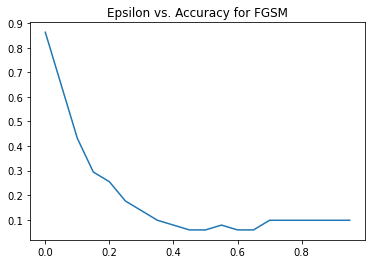

In [ ]:
plt.plot(epsilon_range, accs)
plt.title("Epsilon vs. Accuracy for FGSM")

## Results for PGD

In [60]:
iteration_range = np.arange(2, 51, 2)
accs = []
loss = nn.CrossEntropyLoss()

for iteration in iteration_range:
  losses = 0
  adv_attack = GradientAttack(loss, 0.1) 
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input = adv_attack.forward(input, label, model, num_iter=iteration)
    
    model.eval()
    out = model.lstm_block(input)
    losses += loss(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
    
  accs.append(losses / len(test_dataloader))
  print(losses / len(test_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


5.11259461807854
8.89475544761209
10.25697883905149
10.909817676918179
11.371799076304717
11.768354920779958
12.040575588450713
12.25114543765199
12.397087415059408
12.514168421427408
12.588468420739268
12.63459908728506
12.673132111044492
12.691571216957241
12.70857302347819
12.719550170150457
12.725254713320265
12.72528996187098
12.74039451748717
12.739738913143382
12.742705251656327
12.749278498630897
12.74870958515242
12.74598170261757
12.756462209364948


Text(0.5, 1.0, 'Iteration vs. Accuracy for PGM')

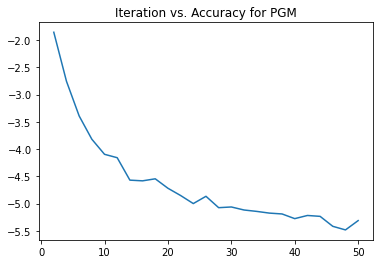

In [ ]:
plt.plot(iteration_range, [-i for i in accs])
plt.title("Iteration vs. Accuracy for PGM")

In [66]:
iteration_range = np.arange(2, 51, 2)
accs2 = []
loss = nn.CrossEntropyLoss()

for iteration in iteration_range:
  losses = 0
  adv_attack2 = HAttack(loss, 0.1)
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input = adv_attack2.forward(input, label, model, num_iter=iteration, pmp_iter=2)

    model.eval()
    out = model.lstm_block(input)
    losses += loss(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
  accs2.append(losses / len(test_dataloader))
  print(losses / len(test_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


8.74065674052519
10.951149267308852
11.77190075668634
12.26312224070231
12.521677017211914
12.643019975400438
12.705698069404153
12.74011832592534
12.752441855037913
12.760203006220799
12.766189032909917
12.769207599116307
12.77851744259105
12.785858715281767
12.781585899053836
12.7898655685724
12.784029063056497
12.793549462860705
12.788945141960593
12.793237517861758
12.796415609471937
12.794150576871985
12.788183922861137
12.796575770658606
12.789764497794357


Text(0.5, 1.0, 'Iteration vs. Loss, alpha=0.01')

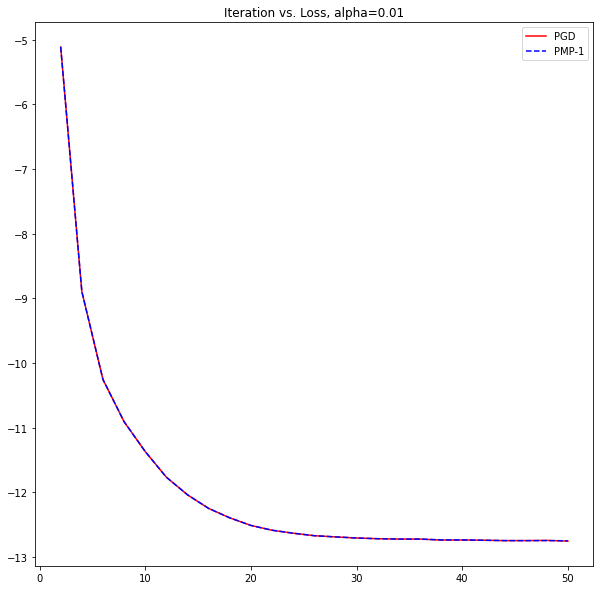

In [65]:
plt.figure(figsize=(10,10))
plt.plot(iteration_range, [-i for i in accs], 'r-', label='PGD')
plt.plot(iteration_range, [-i for i in accs2], 'b--', label='PMP-1')
plt.legend()
plt.title("Iteration vs. Loss, alpha=0.01")

Text(0.5, 1.0, 'Iteration vs. Loss, alpha=0.01')

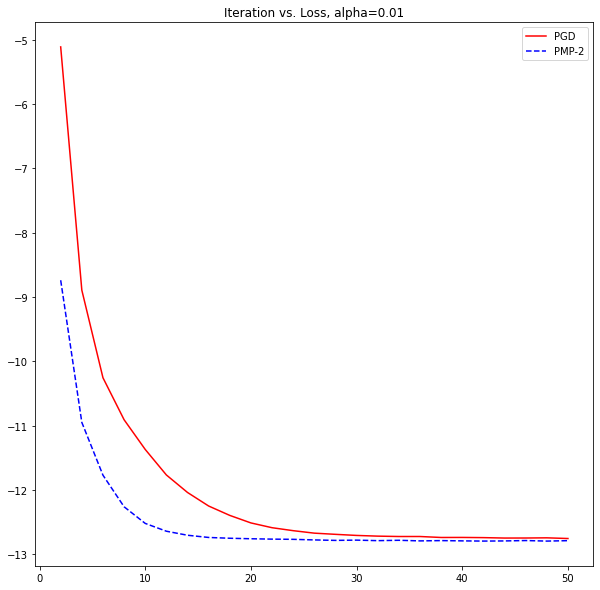

In [68]:
plt.figure(figsize=(10,10))
plt.plot(iteration_range, [-i for i in accs], 'r-', label='PGD')
plt.plot(iteration_range, [-i for i in accs2], 'b--', label='PMP-2')
plt.legend()
plt.title("Iteration vs. Loss, alpha=0.01")